In [1]:
import pandas as pd
import numpy as np
import random 

import statsmodels.formula.api as sm
import sys
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

sys.version

'3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]'

In [2]:
!pip show statsmodels

Name: statsmodels
Version: 0.8.0
Summary: Statistical computations and models for Python
Home-page: http://www.statsmodels.org/
Author: Skipper Seabold, Josef Perktold
Author-email: pystatsmodels@googlegroups.com
License: BSD License
Location: /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages
Requires: scipy, pandas, patsy
Required-by: 


In [3]:
### read in raw data

d = pd.read_csv('../data/raw_data.csv')
d = d.dropna(how='any')
d.head()

,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,stagger_drug_resistant_trend,is_suspicious
0,3/10/18,eca- front desk,gym,0.0,1594,0.0,Nikki,0,0,0,39,0.0
1,3/11/18,eca- front desk,gym,0.0,1583,11.0,Nikki,0,44,0,0,0.0
2,3/12/18,eca- front desk,gym,0.0,1573,10.0,Nikki,0,0,0,44,0.0
3,3/13/18,eca- front desk,gym,0.0,1566,7.0,Nikki,0,62,0,0,0.0
4,3/14/18,eca- front desk,gym,0.0,1549,17.0,Nikki,0,12,0,62,0.0


In [4]:
d.shape

(213, 12)

In [5]:
### get summary stats for treatment useage
d[d['treatment'] == 1]['amount_used'].describe()

count     78.000000
mean      11.935897
std       31.008729
min       -4.000000
25%        3.000000
50%        7.000000
75%       12.000000
max      273.000000
Name: amount_used, dtype: float64

In [6]:
### get summary stats for control useage
d[d['treatment'] == 0]['amount_used'].describe()

count    135.000000
mean       7.629630
std       26.690806
min     -158.000000
25%        1.000000
50%        5.000000
75%        9.000000
max      203.000000
Name: amount_used, dtype: float64

In [7]:
### find difference in means for ctrl/treatment
diff_mean = (d[d['treatment'] == 1]['amount_used'].describe()['mean'] - d[d['treatment'] == 0]['amount_used'].describe()['mean'])
diff_mean

4.306267806267806

In [8]:
### create numeric mapping for locations
unique_locs = d.location.value_counts().index.tolist()
loc_map = [x for x in range(len(unique_locs))]
loc_set = dict(zip(unique_locs, loc_map))
#loc_set

d['numeric_location'] = d['location'].map(lambda x: loc_set[x] if x in loc_set.keys() else -1)
d.head()
#d['Location'].value_counts().sum()

,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,stagger_drug_resistant_trend,is_suspicious,numeric_location
0,3/10/18,eca- front desk,gym,0.0,1594,0.0,Nikki,0,0,0,39,0.0,0
1,3/11/18,eca- front desk,gym,0.0,1583,11.0,Nikki,0,44,0,0,0.0,0
2,3/12/18,eca- front desk,gym,0.0,1573,10.0,Nikki,0,0,0,44,0.0,0
3,3/13/18,eca- front desk,gym,0.0,1566,7.0,Nikki,0,62,0,0,0.0,0
4,3/14/18,eca- front desk,gym,0.0,1549,17.0,Nikki,0,12,0,62,0.0,0


In [9]:
loc_set

{'eca- front desk': 0,
 'yarn shop': 1,
 'Avalon - Gym': 2,
 'ped- not well': 3,
 'concur - 3rd floor': 4,
 'ped - well': 5,
 'concur - 16th floor': 6,
 'concur - 10th floor': 7,
 'concur -12th floor': 8,
 'concur - 5th floor': 9,
 'Avalon - Lobby': 10}

In [10]:
d.tail()

,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,stagger_drug_resistant_trend,is_suspicious,numeric_location
216,4/9/18,Avalon - Gym,gym,0.0,1756,7.0,Carmen,0,38,0,15,0.0,2
217,4/10/18,Avalon - Gym,gym,0.0,1749,7.0,Carmen,0,50,0,38,0.0,2
218,4/11/18,Avalon - Gym,gym,0.0,1742,7.0,Carmen,0,51,0,50,0.0,2
219,4/12/18,Avalon - Gym,gym,0.0,1740,2.0,Carmen,0,38,0,51,0.0,2
220,4/13/18,Avalon - Gym,gym,0.0,1735,5.0,Carmen,16,80,0,38,0.0,2


In [11]:
d['numeric_location'].value_counts()

0     28
1     27
6     20
5     20
4     20
3     20
2     20
8     19
7     19
9     16
10     4
Name: numeric_location, dtype: int64

In [12]:
### without clustering, without ignoring outliers, just straight OLS

ols_revised = sm.ols(formula="amount_used ~ treatment", data=d).fit(use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.141
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.287
Time:                        21:01:21   Log-Likelihood:                -1013.6
No. Observations:                 213   AIC:                             2031.
Df Residuals:                     211   BIC:                             2038.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6296      2.439      3.128      0.002       2.849      12.411
treatment      4.3063      4.031      1.068      0.285      -3.594      12.207
==============================================================================
Omnibus:                      265.643   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24078.949
Skew:                           5.001   Prob(JB):                         0.00
Kurtosis:                      54.118   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
### run a quick linear regression with clustering on location

ols_revised = sm.ols(formula="amount_used ~ treatment", data=d).fit(
                                                        cov_type='cluster',
                                                        cov_kwds={'groups': d['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                    0.9112
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.362
Time:                        21:02:05   Log-Likelihood:                -1013.6
No. Observations:                 213   AIC:                             2031.
Df Residuals:                     211   BIC:                             2038.
Df Model:                           1                                         
Covariance Type:              cluster                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6296      3.016      2.530      0.030       0.909      14.350
treatment      4.3063      4.511      0.955      0.362      -5.745      14.358
==============================================================================
Omnibus:                      265.643   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24078.949
Skew:                           5.001   Prob(JB):                         0.00
Kurtosis:                      54.118   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

In [14]:
### We can see from the results that the p-value for treatment is not below the Z test

In [15]:
### check out when adding in google trends for "flu second wave"
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + treatment*google_second_wave_trend",
                                                        data=d).fit(
                                                        cov_type='cluster',
                                                        cov_kwds={'groups': d['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.4293
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.737
Time:                        21:02:59   Log-Likelihood:                -1013.4
No. Observations:                 213   AIC:                             2035.
Df Residuals:                     209   BIC:                             2048.
Df Model:                           3                                         
Covariance Type:              cluster                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              7.5372      2.526      2.984      0.014       1.910      13.165
treatment                              3.0103      2.932      1.027      0.329      -3.524       9.544
google_second_wave_trend               0.0075      0.107      0.070      0.946      -0.231       0.246
treatment:google_second_wave_trend     0.0443      0.137      0.325      0.752      -0.260       0.349
==============================================================================
Omnibus:                      264.277   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23692.306
Skew:                           4.958   Prob(JB):                         0.00
Kurtosis:                      53.707   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

In [16]:
### check out when adding in google trends for "drug resistant"
ols_revised = sm.ols(formula="amount_used ~ treatment + google_drug_resistant_trend + treatment*google_drug_resistant_trend",
                                                        data=d).fit(
                                                        cov_type='cluster',
                                                        cov_kwds={'groups': d['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                     3.301
Date:                Tue, 17 Apr 2018   Prob (F-statistic):             0.0660
Time:                        21:03:25   Log-Likelihood:                -1013.0
No. Observations:                 213   AIC:                             2034.
Df Residuals:                     209   BIC:                             2047.
Df Model:                           3                                         
Covariance Type:              cluster                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                10.9791      5.139      2.136      0.058      -0.472      22.430
treatment                                 3.7829      7.161      0.528      0.609     -12.172      19.738
google_drug_resistant_trend              -0.0852      0.058     -1.481      0.169      -0.213       0.043
treatment:google_drug_resistant_trend     0.0225      0.074      0.303      0.768      -0.143       0.188
==============================================================================
Omnibus:                      264.265   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23924.806
Skew:                           4.953   Prob(JB):                         0.00
Kurtosis:                      53.967   Cond. No.                         224.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

In [17]:
###next steps:
### add in dummies for location and then add them into the OLS formula
dum = pd.get_dummies(d['location'])
d = pd.concat([d, dum], axis = 1)
d.head()

,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,...,Avalon - Lobby,concur - 10th floor,concur - 16th floor,concur - 3rd floor,concur - 5th floor,concur -12th floor,eca- front desk,ped - well,ped- not well,yarn shop
0,3/10/18,eca- front desk,gym,0.0,1594,0.0,Nikki,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,3/11/18,eca- front desk,gym,0.0,1583,11.0,Nikki,0,44,0,...,0,0,0,0,0,0,1,0,0,0
2,3/12/18,eca- front desk,gym,0.0,1573,10.0,Nikki,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,3/13/18,eca- front desk,gym,0.0,1566,7.0,Nikki,0,62,0,...,0,0,0,0,0,0,1,0,0,0
4,3/14/18,eca- front desk,gym,0.0,1549,17.0,Nikki,0,12,0,...,0,0,0,0,0,0,1,0,0,0


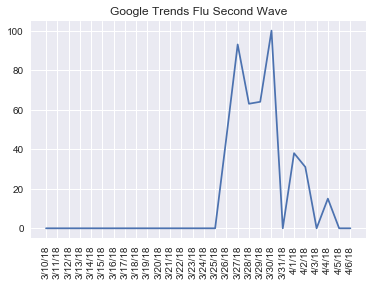

In [18]:
plt.plot(d['date'][:28], d['google_second_wave_trend'][:28])
plt.title('Google Trends Flu Second Wave')
plt.xticks(d['date'][:28], d['date'][:28], rotation='vertical')
plt.show()

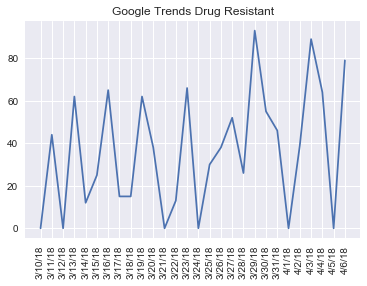

In [19]:
plt.plot(d['date'][:28], d['google_drug_resistant_trend'][:28])
plt.title('Google Trends Drug Resistant')
plt.xticks(d['date'][:28], d['date'][:28], rotation='vertical')
plt.show()

In [20]:
from pathlib import Path
import pandas as pd
import numpy as np
import random 

import statsmodels.formula.api as sm
import math
from sklearn import linear_model

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

import datetime
import sys

### for debugging purposes
###sys.version
### should say:
###'3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) \n
###[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

### begin ETL

d = pd.read_csv('../data/raw_data.csv')
d_working = d.dropna(how='any')

### create numeric mapping for locations
unique_locs = d.location.value_counts().index.tolist()
loc_map = [x for x in range(len(unique_locs))]
loc_set = dict(zip(unique_locs, loc_map))
#loc_set

d_working['numeric_location'] = d_working['location'].map(lambda x: loc_set[x] if x in loc_set.keys() else -1)

### get dummies for locations
dum = pd.get_dummies(d_working['numeric_location'])
dum.columns = ['loc_%s' % (x) for x in dum.columns.tolist()]
d_working = pd.concat([d_working, dum], axis = 1)

### create week aggregates

def week_num(date_string):
    date = datetime.datetime.strptime(date_string,'%m/%d/%y')
    return datetime.date.isocalendar(date)[1]

d_working['week_number'] = d_working['date'].apply(week_num)

d_working.head()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,location,location_type,treatment,as_measured,amount_used,collector,google_second_wave_trend,google_drug_resistant_trend,stagger_second_wave_trend,...,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10,week_number
0,3/10/18,eca- front desk,gym,0.0,1594,0.0,Nikki,0,0,0,...,0,0,0,0,0,0,0,0,0,10
1,3/11/18,eca- front desk,gym,0.0,1583,11.0,Nikki,0,44,0,...,0,0,0,0,0,0,0,0,0,10
2,3/12/18,eca- front desk,gym,0.0,1573,10.0,Nikki,0,0,0,...,0,0,0,0,0,0,0,0,0,11
3,3/13/18,eca- front desk,gym,0.0,1566,7.0,Nikki,0,62,0,...,0,0,0,0,0,0,0,0,0,11
4,3/14/18,eca- front desk,gym,0.0,1549,17.0,Nikki,0,12,0,...,0,0,0,0,0,0,0,0,0,11


In [21]:
ols_revised = sm.ols(formula="amount_used ~ treatment + stagger_second_wave_trend + stagger_drug_resistant_trend",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6703
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.571
Time:                        21:05:52   Log-Likelihood:                -1013.1
No. Observations:                 213   AIC:                             2034.
Df Residuals:                     209   BIC:                             2048.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        5.6242      3.386      1.661      0.097      -1.012      12.260
treatment                        4.1862      4.131      1.013      0.311      -3.911      12.283
stagger_second_wave_trend       -0.0231      0.075     -0.307      0.759      -0.170       0.124
stagger_drug_resistant_trend     0.0703      0.075      0.934      0.350      -0.077       0.218
==============================================================================
Omnibus:                      267.371   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24106.716
Skew:                           5.064   Prob(JB):                         0.00
Kurtosis:                      54.124   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
d_working.columns

Index(['date', 'location', 'location_type', 'treatment', 'as_measured',
       'amount_used', 'collector', 'google_second_wave_trend',
       'google_drug_resistant_trend', 'stagger_second_wave_trend',
       'stagger_drug_resistant_trend', 'is_suspicious', 'numeric_location',
       'loc_0', 'loc_1', 'loc_2', 'loc_3', 'loc_4', 'loc_5', 'loc_6', 'loc_7',
       'loc_8', 'loc_9', 'loc_10', 'week_number'],
      dtype='object')

In [23]:
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + google_drug_resistant_trend",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9315
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.426
Time:                        21:06:08   Log-Likelihood:                -1012.7
No. Observations:                 213   AIC:                             2033.
Df Residuals:                     209   BIC:                             2047.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      10.4718      3.697      2.833      0.005       3.226      17.717
treatment                       4.1541      4.146      1.002      0.316      -3.972      12.280
google_second_wave_trend        0.0451      0.065      0.689      0.491      -0.083       0.173
google_drug_resistant_trend    -0.0864      0.072     -1.203      0.229      -0.227       0.054
==============================================================================
Omnibus:                      261.420   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23306.105
Skew:                           4.862   Prob(JB):                         0.00
Kurtosis:                      53.314   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
ols_revised = sm.ols(formula="amount_used ~ treatment + stagger_second_wave_trend + stagger_drug_resistant_trend + google_second_wave_trend + google_drug_resistant_trend",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6562
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.657
Time:                        21:06:40   Log-Likelihood:                -1012.5
No. Observations:                 213   AIC:                             2037.
Df Residuals:                     207   BIC:                             2057.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        8.9713      4.794      1.871      0.061      -0.425      18.368
treatment                        4.1694      4.169      1.000      0.317      -4.001      12.340
stagger_second_wave_trend       -0.0579      0.109     -0.532      0.595      -0.272       0.156
stagger_drug_resistant_trend     0.0408      0.080      0.512      0.609      -0.116       0.197
google_second_wave_trend         0.0693      0.099      0.703      0.482      -0.124       0.262
google_drug_resistant_trend     -0.0729      0.075     -0.969      0.333      -0.220       0.075
==============================================================================
Omnibus:                      263.103   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23169.209
Skew:                           4.926   Prob(JB):                         0.00
Kurtosis:                      53.135   Cond. No.                         175.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
d_week = d_working.groupby(['week_number', 'treatment', 'numeric_location']).sum()
d_week.reset_index(inplace=True)
d_week = d_week[['week_number', 'treatment', 'numeric_location', 'amount_used',
       'google_second_wave_trend', 'google_drug_resistant_trend',
       'is_suspicious', 'stagger_second_wave_trend', 'stagger_drug_resistant_trend']]

loc_dum = pd.get_dummies(d_week['numeric_location'])
loc_dum.columns = ['loc_%s' % (x) for x in loc_dum.columns.tolist()]
d_working = pd.concat([d_week, loc_dum], axis = 1)
d_working.head()

,week_number,treatment,numeric_location,amount_used,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,stagger_second_wave_trend,stagger_drug_resistant_trend,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,10,0.0,0,4.0,0,52,0.0,0,52,1,0,0,0,0,0,0,0,0,0,0
1,10,0.0,1,11.0,0,44,0.0,0,39,0,1,0,0,0,0,0,0,0,0,0
2,10,0.0,3,73.0,0,139,0.0,0,115,0,0,0,1,0,0,0,0,0,0,0
3,10,0.0,5,53.0,0,139,0.0,0,115,0,0,0,0,0,1,0,0,0,0,0
4,10,0.0,10,4.0,0,44,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [27]:
d_working.shape

(48, 20)

In [30]:
ols_revised = sm.ols(formula="amount_used ~ treatment \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.148
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.355
Time:                        21:09:32   Log-Likelihood:                -261.22
No. Observations:                  48   AIC:                             546.4
Df Residuals:                      36   BIC:                             568.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8512     26.559      0.032      0.974     -51.203      52.906
treatment     13.8926     20.320      0.684      0.494     -25.934      53.719
loc_1         44.5358     37.864      1.176      0.240     -29.676     118.748
loc_2         26.4256     41.685      0.634      0.526     -55.275     108.127
loc_3         63.9525     42.198      1.516      0.130     -18.753     146.658
loc_4          0.4525     42.198      0.011      0.991     -82.253      83.158
loc_5         94.1756     41.685      2.259      0.024      12.475     175.877
loc_6         33.4256     41.685      0.802      0.423     -48.275     115.127
loc_7          4.9256     41.685      0.118      0.906     -76.775      86.627
loc_8         84.2025     42.198      1.995      0.046       1.497     166.908
loc_9         43.9525     42.198      1.042      0.298     -38.753     126.658
loc_10         2.6756     41.685      0.064      0.949     -79.025      84.377
==============================================================================
Omnibus:                       26.425   Durbin-Watson:                   2.452
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.892
Skew:                           1.075   Prob(JB):                     1.25e-27
Kurtosis:                      10.571   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
ols_revised = sm.ols(formula="amount_used ~ treatment + stagger_second_wave_trend + stagger_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     1.260
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.283
Time:                        21:09:54   Log-Likelihood:                -259.00
No. Observations:                  48   AIC:                             546.0
Df Residuals:                      34   BIC:                             572.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      -29.1216     36.596     -0.796      0.426    -100.849      42.606
treatment                        5.2141     20.554      0.254      0.800     -35.070      45.498
stagger_second_wave_trend        0.0701      0.123      0.569      0.569      -0.171       0.311
stagger_drug_resistant_trend     0.1541      0.187      0.825      0.409      -0.212       0.520
loc_1                           48.2246     37.258      1.294      0.196     -24.800     121.249
loc_2                           31.8696     41.414      0.770      0.442     -49.300     113.039
loc_3                           69.5335     41.580      1.672      0.094     -11.962     151.029
loc_4                            1.5965     41.462      0.039      0.969     -79.667      82.860
loc_5                           97.5870     41.013      2.379      0.017      17.204     177.970
loc_6                           32.4000     40.959      0.791      0.429     -47.878     112.678
loc_7                            5.5946     41.017      0.136      0.892     -74.797      85.986
loc_8                           90.8925     42.073      2.160      0.031       8.432     173.353
loc_9                           46.7911     41.534      1.127      0.260     -34.614     128.196
loc_10                          31.3132     46.576      0.672      0.501     -59.974     122.600
==============================================================================
Omnibus:                       19.777   Durbin-Watson:                   2.583
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.532
Skew:                           0.499   Prob(JB):                     3.66e-25
Kurtosis:                      10.434   Cond. No.                     2.08e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.08e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
ols_revised = sm.ols(formula="amount_used ~ treatment + stagger_second_wave_trend + stagger_drug_resistant_trend \
                            + stagger_second_wave_trend * stagger_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     1.166
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.344
Time:                        21:10:41   Log-Likelihood:                -258.79
No. Observations:                  48   AIC:                             547.6
Df Residuals:                      33   BIC:                             575.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                -33.1750     37.747     -0.879      0.379    -107.159      40.809
treatment                                                  4.4707     20.818      0.215      0.830     -36.332      45.273
stagger_second_wave_trend                                  0.3205      0.483      0.664      0.507      -0.625       1.266
stagger_drug_resistant_trend                               0.1830      0.196      0.933      0.351      -0.202       0.568
stagger_second_wave_trend:stagger_drug_resistant_trend    -0.0010      0.002     -0.537      0.591      -0.005       0.003
loc_1                                                     50.7691     37.951      1.338      0.181     -23.613     125.151
loc_2                                                     30.0388     41.993      0.715      0.474     -52.265     112.343
loc_3                                                     68.2853     42.087      1.622      0.105     -14.203     150.773
loc_4                                                     -1.5344     42.306     -0.036      0.971     -84.452      81.383
loc_5                                                     96.1529     41.535      2.315      0.021      14.747     177.559
loc_6                                                     29.0833     41.852      0.695      0.487     -52.946     111.112
loc_7                                                      2.5967     41.827      0.062      0.950     -79.382      84.576
loc_8                                                     88.8050     42.697      2.080      0.038       5.120     172.490
loc_9                                                     43.9791     42.301      1.040      0.298     -38.929     126.887
loc_10                                                    34.8932     47.540      0.734      0.463     -58.284     128.071
==============================================================================
Omnibus:                       18.454   Durbin-Watson:                   2.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.396
Skew:                           0.310   Prob(JB):                     3.92e-25
Kurtosis:                      10.471   Cond. No.                     3.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_working).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     1.179
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.335
Time:                        21:11:21   Log-Likelihood:                -258.71
No. Observations:                  48   AIC:                             547.4
Df Residuals:                      33   BIC:                             575.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              -20.3535     39.668     -0.513      0.608     -98.102      57.395
treatment                                                2.4483     21.264      0.115      0.908     -39.229      44.125
google_second_wave_trend                                 0.5448      0.784      0.695      0.487      -0.992       2.082
google_drug_resistant_trend                              0.1042      0.205      0.510      0.610      -0.297       0.505
google_second_wave_trend:google_drug_resistant_trend    -0.0016      0.003     -0.558      0.577      -0.007       0.004
loc_1                                                   47.8391     37.605      1.272      0.203     -25.866     121.544
loc_2                                                   26.0642     43.715      0.596      0.551     -59.616     111.745
loc_3                                                   60.7391     42.144      1.441      0.150     -21.861     143.340
loc_4                                                   -7.4152     43.096     -0.172      0.863     -91.882      77.051
loc_5                                                   88.1012     41.828      2.106      0.035       6.121     170.082
loc_6                                                   22.6969     42.957      0.528      0.597     -61.496     106.890
loc_7                                                   -5.8031     42.957     -0.135      0.893     -89.996      78.390
loc_8                                                   77.6640     42.599      1.823      0.068      -5.829     161.157
loc_9                                                   36.0848     43.096      0.837      0.402     -48.382     120.551
loc_10                                                  19.6369     48.531      0.405      0.686     -75.481     114.755
==============================================================================
Omnibus:                       17.076   Durbin-Watson:                   2.617
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.155
Skew:                           0.361   Prob(JB):                     5.32e-19
Kurtosis:                       9.446   Cond. No.                     4.51e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
d_working.columns

Index(['week_number', 'treatment', 'numeric_location', 'amount_used',
       'google_second_wave_trend', 'google_drug_resistant_trend',
       'is_suspicious', 'stagger_second_wave_trend',
       'stagger_drug_resistant_trend', 'loc_0', 'loc_1', 'loc_2', 'loc_3',
       'loc_4', 'loc_5', 'loc_6', 'loc_7', 'loc_8', 'loc_9', 'loc_10'],
      dtype='object')

In [35]:
d_working.head()

,week_number,treatment,numeric_location,amount_used,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,stagger_second_wave_trend,stagger_drug_resistant_trend,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
0,10,0.0,0,4.0,0,52,0.0,0,52,1,0,0,0,0,0,0,0,0,0,0
1,10,0.0,1,11.0,0,44,0.0,0,39,0,1,0,0,0,0,0,0,0,0,0
2,10,0.0,3,73.0,0,139,0.0,0,115,0,0,0,1,0,0,0,0,0,0,0
3,10,0.0,5,53.0,0,139,0.0,0,115,0,0,0,0,0,1,0,0,0,0,0
4,10,0.0,10,4.0,0,44,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [36]:
#### drop low locations
d_high = d_working[d_working['amount_used'] >5]
d_high.shape
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_high).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     1.562
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.173
Time:                        21:11:57   Log-Likelihood:                -187.08
No. Observations:                  36   AIC:                             404.2
Df Residuals:                      21   BIC:                             427.9
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                              -97.5939     86.293     -1.131      0.258    -266.724      71.537
treatment                                              -17.1846     21.949     -0.783      0.434     -60.204      25.834
google_second_wave_trend                                 0.7411      0.867      0.855      0.393      -0.958       2.440
google_drug_resistant_trend                              0.4767      0.245      1.948      0.051      -0.003       0.956
google_second_wave_trend:google_drug_resistant_trend    -0.0026      0.003     -0.802      0.422      -0.009       0.004
loc_1                                                   77.6217     68.592      1.132      0.258     -56.816     212.059
loc_2                                                   28.1422     66.679      0.422      0.673    -102.547     158.831
loc_3                                                   84.0900     68.921      1.220      0.222     -50.994     219.174
loc_4                                                   36.9359     73.707      0.501      0.616    -107.528     181.400
loc_5                                                  106.5438     69.930      1.524      0.128     -30.516     243.604
loc_6                                                   29.6513     68.216      0.435      0.664    -104.050     163.353
loc_7                                                   -3.8819     77.451     -0.050      0.960    -155.683     147.920
loc_8                                                   94.2751     67.831      1.390      0.165     -38.671     227.221
loc_9                                                  124.6747     70.112      1.778      0.075     -12.742     262.091
loc_10                                                  98.5307     91.240      1.080      0.280     -80.296     277.357
==============================================================================
Omnibus:                        7.385   Durbin-Watson:                   2.481
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                5.995
Skew:                           0.814   Prob(JB):                       0.0499
Kurtosis:                       4.160   Cond. No.                     1.02e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + google_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_high).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     1.659
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.143
Time:                        21:12:22   Log-Likelihood:                -187.62
No. Observations:                  36   AIC:                             403.2
Df Residuals:                      22   BIC:                             425.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -79.7915     82.712     -0.965      0.335    -241.904      82.321
treatment                     -15.1812     21.629     -0.702      0.483     -57.573      27.211
google_second_wave_trend        0.0498      0.095      0.525      0.600      -0.136       0.236
google_drug_resistant_trend     0.4016      0.224      1.791      0.073      -0.038       0.841
loc_1                          67.1691     66.795      1.006      0.315     -63.747     198.085
loc_2                          26.1111     66.089      0.395      0.693    -103.421     155.643
loc_3                          79.6729     68.142      1.169      0.242     -53.884     213.229
loc_4                          31.0034     72.739      0.426      0.670    -111.562     173.569
loc_5                         102.6275     69.192      1.483      0.138     -32.986     238.241
loc_6                          28.0513     67.633      0.415      0.678    -104.506     160.609
loc_7                          -4.2808     76.820     -0.056      0.956    -154.844     146.283
loc_8                          91.2173     67.173      1.358      0.174     -40.439     222.873
loc_9                         121.2419     69.412      1.747      0.081     -14.803     257.287
loc_10                         93.4238     90.277      1.035      0.301     -83.516     270.364
==============================================================================
Omnibus:                        9.454   Durbin-Watson:                   2.365
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                8.463
Skew:                           0.957   Prob(JB):                       0.0145
Kurtosis:                       4.406   Cond. No.                     5.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
loc_set

{'yarn shop': 0,
 'eca- front desk': 1,
 'Avalon - Gym': 2,
 'ped- not well': 3,
 'concur - 3rd floor': 4,
 'ped - well': 5,
 'concur - 16th floor': 6,
 'concur - 10th floor': 7,
 'concur - 5th floor': 8,
 'concur -12th floor': 9,
 'Avalon - Lobby': 10}

In [39]:
d_high.columns

Index(['week_number', 'treatment', 'numeric_location', 'amount_used',
       'google_second_wave_trend', 'google_drug_resistant_trend',
       'is_suspicious', 'stagger_second_wave_trend',
       'stagger_drug_resistant_trend', 'loc_0', 'loc_1', 'loc_2', 'loc_3',
       'loc_4', 'loc_5', 'loc_6', 'loc_7', 'loc_8', 'loc_9', 'loc_10'],
      dtype='object')

In [40]:
# NOTE FROM CARMEN: This model doesn't include the treatment variable

ols_revised = sm.ols(formula="amount_used ~ google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_high).fit(
#                                                         cov_type='cluster',
#                                                         cov_kwds={'groups': d_working['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                     1.664
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.141
Time:                        21:13:12   Log-Likelihood:                -187.60
No. Observations:                  36   AIC:                             403.2
Df Residuals:                      22   BIC:                             425.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                             -109.0432     84.293     -1.294      0.196    -274.255      56.168
google_second_wave_trend                                 0.6536      0.852      0.767      0.443      -1.017       2.324
google_drug_resistant_trend                              0.4555      0.241      1.889      0.059      -0.017       0.928
google_second_wave_trend:google_drug_resistant_trend    -0.0023      0.003     -0.724      0.469      -0.009       0.004
loc_1                                                   84.4195     67.439      1.252      0.211     -47.758     216.597
loc_2                                                   40.0737     64.341      0.623      0.533     -86.032     166.179
loc_3                                                   91.9308     67.588      1.360      0.174     -40.538     224.400
loc_4                                                   43.4312     72.592      0.598      0.550     -98.846     185.709
loc_5                                                  118.6808     67.588      1.756      0.079     -13.788     251.150
loc_6                                                   42.5942     65.598      0.649      0.516     -85.976     171.165
loc_7                                                   14.3210     73.227      0.196      0.845    -129.200     157.842
loc_8                                                  102.6514     66.390      1.546      0.122     -27.470     232.773
loc_9                                                  130.3298     69.123      1.885      0.059      -5.148     265.808
loc_10                                                 103.2096     90.239      1.144      0.253     -73.657     280.076
==============================================================================
Omnibus:                        7.678   Durbin-Watson:                   2.456
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.309
Skew:                           0.841   Prob(JB):                       0.0427
Kurtosis:                       4.173   Cond. No.                     1.01e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# NOTE FROM CARMEN: This model doesn't include the treatment variable

ols_revised = sm.ols(formula="amount_used ~ google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_high).fit(
                                                         cov_type='cluster',
                                                         cov_kwds={'groups': d_high['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.198
Method:                 Least Squares   F-statistic:                 4.279e+15
Date:                Tue, 17 Apr 2018   Prob (F-statistic):           6.47e-77
Time:                        21:13:34   Log-Likelihood:                -187.60
No. Observations:                  36   AIC:                             403.2
Df Residuals:                      22   BIC:                             425.4
Df Model:                          13                                         
Covariance Type:              cluster                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                             -109.0432     64.482     -1.691      0.122    -252.718      34.631
google_second_wave_trend                                 0.6536      0.793      0.825      0.429      -1.112       2.419
google_drug_resistant_trend                              0.4555      0.250      1.825      0.098      -0.101       1.011
google_second_wave_trend:google_drug_resistant_trend    -0.0023      0.003     -0.913      0.383      -0.008       0.003
loc_1                                                   84.4195     28.778      2.933      0.015      20.297     148.542
loc_2                                                   40.0737     11.155      3.592      0.005      15.219      64.928
loc_3                                                   91.9308     26.564      3.461      0.006      32.743     151.118
loc_4                                                   43.4312     21.770      1.995      0.074      -5.076      91.939
loc_5                                                  118.6808     26.564      4.468      0.001      59.493     177.868
loc_6                                                   42.5942     21.144      2.014      0.072      -4.518      89.707
loc_7                                                   14.3210     33.320      0.430      0.676     -59.920      88.562
loc_8                                                  102.6514     23.700      4.331      0.001      49.843     155.459
loc_9                                                  130.3298     27.349      4.765      0.001      69.393     191.267
loc_10                                                 103.2096     60.251      1.713      0.117     -31.038     237.457
==============================================================================
Omnibus:                        7.678   Durbin-Watson:                   2.456
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                6.309
Skew:                           0.841   Prob(JB):                       0.0427
Kurtosis:                       4.173   Cond. No.                     1.01e+06
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# NOTE FROM CARMEN: This model doesn't include the treatment variable

ols_revised = sm.ols(formula="amount_used ~ stagger_second_wave_trend + stagger_drug_resistant_trend \
                            + stagger_second_wave_trend * stagger_drug_resistant_trend  \
                            + loc_1 + loc_2 + loc_3 + loc_4 + loc_5 + loc_6 + loc_7 \
                            + loc_8 + loc_9 + loc_10",
                                                        data=d_high).fit(
                                                         cov_type='cluster',
                                                         cov_kwds={'groups': d_high['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                 1.197e+15
Date:                Tue, 17 Apr 2018   Prob (F-statistic):           3.77e-74
Time:                        21:14:23   Log-Likelihood:                -186.52
No. Observations:                  36   AIC:                             401.0
Df Residuals:                      22   BIC:                             423.2
Df Model:                          13                                         
Covariance Type:              cluster                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               -115.5835     31.016     -3.727      0.004    -184.691     -46.476
stagger_second_wave_trend                                  0.5619      0.600      0.937      0.371      -0.774       1.898
stagger_drug_resistant_trend                               0.4721      0.129      3.659      0.004       0.185       0.760
stagger_second_wave_trend:stagger_drug_resistant_trend    -0.0022      0.002     -1.285      0.228      -0.006       0.002
loc_1                                                     96.5216     17.509      5.513      0.000      57.509     135.534
loc_2                                                     66.0220     10.672      6.187      0.000      42.244      89.800
loc_3                                                    110.8934     17.415      6.368      0.000      72.091     149.696
loc_4                                                     64.1072     14.527      4.413      0.001      31.738      96.476
loc_5                                                    137.6434     17.415      7.904      0.000      98.841     176.446
loc_6                                                     64.8075     19.677      3.294      0.008      20.964     108.651
loc_7                                                     37.6107     27.523      1.366      0.202     -23.715      98.937
loc_8                                                    136.0549     23.442      5.804      0.000      83.823     188.287
loc_9                                                    157.3540     21.388      7.357      0.000     109.699     205.009
loc_10                                                   111.1829     27.196      4.088      0.002      50.587     171.779
==============================================================================
Omnibus:                        5.538   Durbin-Watson:                   2.569
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                4.135
Skew:                           0.626   Prob(JB):                        0.127
Kurtosis:                       4.090   Cond. No.                     7.92e+05
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 7.92e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
d_high.columns

Index(['week_number', 'treatment', 'numeric_location', 'amount_used',
       'google_second_wave_trend', 'google_drug_resistant_trend',
       'is_suspicious', 'stagger_second_wave_trend',
       'stagger_drug_resistant_trend', 'loc_0', 'loc_1', 'loc_2', 'loc_3',
       'loc_4', 'loc_5', 'loc_6', 'loc_7', 'loc_8', 'loc_9', 'loc_10'],
      dtype='object')

In [45]:
# NOTE FROM CARMEN: This model doesn't include the treatment variable

ols_revised = sm.ols(formula="amount_used ~ stagger_second_wave_trend + stagger_drug_resistant_trend \
                            + stagger_second_wave_trend * stagger_drug_resistant_trend",
                                                        data=d_high).fit(
                                                         cov_type='cluster',
                                                         cov_kwds={'groups': d_high['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     2.317
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.137
Time:                        21:14:55   Log-Likelihood:                -195.69
No. Observations:                  36   AIC:                             399.4
Df Residuals:                      32   BIC:                             405.7
Df Model:                           3                                         
Covariance Type:              cluster                                         
==========================================================================================================================
                                                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                 15.3315     15.667      0.979      0.351     -19.576      50.239
stagger_second_wave_trend                                  0.6218      0.520      1.195      0.260      -0.537       1.781
stagger_drug_resistant_trend                               0.2028      0.142      1.425      0.185      -0.114       0.520
stagger_second_wave_trend:stagger_drug_resistant_trend    -0.0019      0.001     -1.255      0.238      -0.005       0.001
==============================================================================
Omnibus:                       15.064   Durbin-Watson:                   2.383
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.484
Skew:                           1.266   Prob(JB):                     0.000160
Kurtosis:                       5.289   Cond. No.                     9.16e+04
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 9.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# NOTE FROM CARMEN: This model doesn't include the treatment variable

ols_revised = sm.ols(formula="amount_used ~ google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend",
                                                        data=d_high).fit(
                                                         cov_type='cluster',
                                                         cov_kwds={'groups': d_high['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     10.44
Date:                Tue, 17 Apr 2018   Prob (F-statistic):            0.00201
Time:                        21:15:16   Log-Likelihood:                -195.83
No. Observations:                  36   AIC:                             399.7
Df Residuals:                      32   BIC:                             406.0
Df Model:                           3                                         
Covariance Type:              cluster                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                3.9583     21.104      0.188      0.855     -43.065      50.982
google_second_wave_trend                                 0.4762      0.691      0.689      0.507      -1.065       2.017
google_drug_resistant_trend                              0.2383      0.153      1.559      0.150      -0.102       0.579
google_second_wave_trend:google_drug_resistant_trend    -0.0014      0.002     -0.609      0.556      -0.006       0.004
==============================================================================
Omnibus:                       16.971   Durbin-Watson:                   2.331
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.953
Skew:                           1.393   Prob(JB):                     2.82e-05
Kurtosis:                       5.491   Cond. No.                     1.44e+05
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.44e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
ols_revised = sm.ols(formula="amount_used ~ Treatment + google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend",
                                                        data=d_high).fit(
                                                         cov_type='cluster',
                                                         cov_kwds={'groups': d_high['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                    0.8939
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.502
Time:                        16:55:52   Log-Likelihood:                -196.09
No. Observations:                  36   AIC:                             402.2
Df Residuals:                      31   BIC:                             410.1
Df Model:                           4                                         
Covariance Type:              cluster                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               38.4631     12.413      3.099      0.011      10.806      66.120
Treatment                                               -3.7365     18.553     -0.201      0.844     -45.075      37.602
google_second_wave_trend                                 0.0721      0.305      0.236      0.818      -0.608       0.752
google_drug_resistant_trend                              0.0167      0.098      0.172      0.867      -0.201       0.234
google_second_wave_trend:google_drug_resistant_trend     0.0023      0.005      0.455      0.659      -0.009       0.014
==============================================================================
Omnibus:                       15.572   Durbin-Watson:                   2.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.983
Skew:                           1.329   Prob(JB):                     0.000124
Kurtosis:                       5.220   Cond. No.                     2.21e+04
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 2.21e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
#### try dropping all locations with low use
high_traffic = d_working[(d_working['numeric_location']!= 0) & 
                         (d_working['numeric_location']!=10) &
                         (d_working['numeric_location']!=4) &
                         (d_working['numeric_location']!= 8)]
high_traffic.head()

,week_number,treatment,numeric_location,amount_used,google_second_wave_trend,google_drug_resistant_trend,is_suspicious,stagger_second_wave_trend,stagger_drug_resistant_trend,loc_0,loc_1,loc_2,loc_3,loc_4,loc_5,loc_6,loc_7,loc_8,loc_9,loc_10
1,10,0.0,1,11.0,0,44,0.0,0,39,0,1,0,0,0,0,0,0,0,0,0
2,10,0.0,3,73.0,0,139,0.0,0,115,0,0,0,1,0,0,0,0,0,0,0
3,10,0.0,5,53.0,0,139,0.0,0,115,0,0,0,0,0,1,0,0,0,0,0
6,11,0.0,1,82.0,0,194,0.0,0,223,0,1,0,0,0,0,0,0,0,0,0
7,11,0.0,2,23.0,0,164,0.0,0,143,0,0,1,0,0,0,0,0,0,0,0


In [48]:
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend",
                                                        data=high_traffic).fit(
                                                         cov_type='cluster',
                                                         cov_kwds={'groups': high_traffic['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     99.54
Date:                Tue, 17 Apr 2018   Prob (F-statistic):           1.29e-05
Time:                        21:16:20   Log-Likelihood:                -166.63
No. Observations:                  30   AIC:                             343.3
Df Residuals:                      25   BIC:                             350.3
Df Model:                           4                                         
Covariance Type:              cluster                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               62.5158     63.788      0.980      0.365     -93.567     218.599
treatment                                               28.3296     29.548      0.959      0.375     -43.972     100.631
google_second_wave_trend                                 0.4560      0.881      0.517      0.623      -1.700       2.612
google_drug_resistant_trend                             -0.2112      0.416     -0.508      0.630      -1.229       0.806
google_second_wave_trend:google_drug_resistant_trend    -0.0008      0.003     -0.291      0.781      -0.008       0.006
==============================================================================
Omnibus:                        3.295   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.193   Jarque-Bera (JB):                2.236
Skew:                           0.076   Prob(JB):                        0.327
Kurtosis:                       4.329   Cond. No.                     1.77e+05
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
ols_revised = sm.ols(formula="amount_used ~ treatment + google_second_wave_trend + google_drug_resistant_trend \
                            + google_second_wave_trend * google_drug_resistant_trend",
                                                        data=high_traffic).fit(
                                                         #cov_type='cluster',
                                                         #cov_kwds={'groups': high_traffic['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     1.786
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.163
Time:                        21:16:51   Log-Likelihood:                -166.63
No. Observations:                  30   AIC:                             343.3
Df Residuals:                      25   BIC:                             350.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               62.5158     48.122      1.299      0.194     -31.802     156.834
treatment                                               28.3296     26.732      1.060      0.289     -24.064      80.723
google_second_wave_trend                                 0.4560      1.074      0.424      0.671      -1.650       2.562
google_drug_resistant_trend                             -0.2112      0.255     -0.827      0.408      -0.712       0.289
google_second_wave_trend:google_drug_resistant_trend    -0.0008      0.004     -0.201      0.841      -0.009       0.007
==============================================================================
Omnibus:                        3.295   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.193   Jarque-Bera (JB):                2.236
Skew:                           0.076   Prob(JB):                        0.327
Kurtosis:                       4.329   Cond. No.                     1.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
ols_revised = sm.ols(formula="amount_used ~ treatment",
                                                        data=high_traffic).fit(
                                                         #cov_type='cluster',
                                                         #cov_kwds={'groups': high_traffic['numeric_location']},
                                                         use_t=True)
ols_revised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            amount_used   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     1.671
Date:                Tue, 17 Apr 2018   Prob (F-statistic):              0.207
Time:                        21:17:02   Log-Likelihood:                -169.53
No. Observations:                  30   AIC:                             343.1
Df Residuals:                      28   BIC:                             345.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.6316     16.354      2.301      0.021       5.578      69.685
treatment     34.9139     27.008      1.293      0.196     -18.020      87.848
==============================================================================
Omnibus:                       15.134   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               25.901
Skew:                           0.999   Prob(JB):                     2.38e-06
Kurtosis:                       7.090   Cond. No.                         2.42
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""